# Prepare data

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

import gc

import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
    accuracy_score, 
    precision_score, 
    recall_score
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from lightgbm.sklearn import LGBMRegressor
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

## load data

In [64]:
nba = pd.read_csv('player.csv')

## Quick look

In [65]:
print(nba.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7633 entries, 0 to 7632
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   League       7633 non-null   object 
 1   Season       7633 non-null   object 
 2   Stage        7633 non-null   object 
 3   Player       7633 non-null   object 
 4   Team         7633 non-null   object 
 5   GP           7633 non-null   int64  
 6   MIN          7633 non-null   float64
 7   FGM          7633 non-null   int64  
 8   FGA          7633 non-null   int64  
 9   3PM          7633 non-null   int64  
 10  3PA          7633 non-null   int64  
 11  FTM          7633 non-null   int64  
 12  FTA          7633 non-null   int64  
 13  TOV          7633 non-null   int64  
 14  PF           7633 non-null   int64  
 15  ORB          7633 non-null   int64  
 16  DRB          7633 non-null   int64  
 17  REB          7633 non-null   int64  
 18  AST          7633 non-null   int64  
 19  STL   

In [66]:
nba = nba.drop(columns = ["draft_team", "draft_pick", "high_school","draft_round","nationality","League"
                         ,"Season", "Stage", "Team", "MIN"])

### Feature engineering and cleaning

In [67]:
nba = nba.assign(FTP = nba["FTM"]/nba["FTA"]) # free throw percentage
nba = nba.assign(threePP = nba["3PM"]/nba["3PA"]) # three-point  percentage
nba = nba.assign(FGP = nba["FGM"]/nba["FGA"])  ## field-goal  percentage
nba = nba.assign(scorerate = nba["PTS"]/nba["GP"]) #points per game

In [68]:
#Turnover per game
nba['turnover_per_game'] = nba['TOV'] / nba['GP']

#Fauls per game
nba['fauls_per_game'] = nba['PF'] / nba['GP']

In [69]:
nba = nba.drop("Unnamed: 29", axis = 1)
nba = nba.drop("Unnamed: 30", axis = 1)

In [70]:
nba.dropna()
nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7633 entries, 0 to 7632
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Player             7633 non-null   object 
 1   GP                 7633 non-null   int64  
 2   FGM                7633 non-null   int64  
 3   FGA                7633 non-null   int64  
 4   3PM                7633 non-null   int64  
 5   3PA                7633 non-null   int64  
 6   FTM                7633 non-null   int64  
 7   FTA                7633 non-null   int64  
 8   TOV                7633 non-null   int64  
 9   PF                 7633 non-null   int64  
 10  ORB                7633 non-null   int64  
 11  DRB                7633 non-null   int64  
 12  REB                7633 non-null   int64  
 13  AST                7633 non-null   int64  
 14  STL                7633 non-null   int64  
 15  BLK                7633 non-null   int64  
 16  PTS                7633 

## Define feature / target

In [71]:

feat_cols = ["threePP","FGP","FTP","height","weight","BLK","STL","AST","REB","ORB","DRB","PF","TOV"]
target = 'scorerate'

## EDA

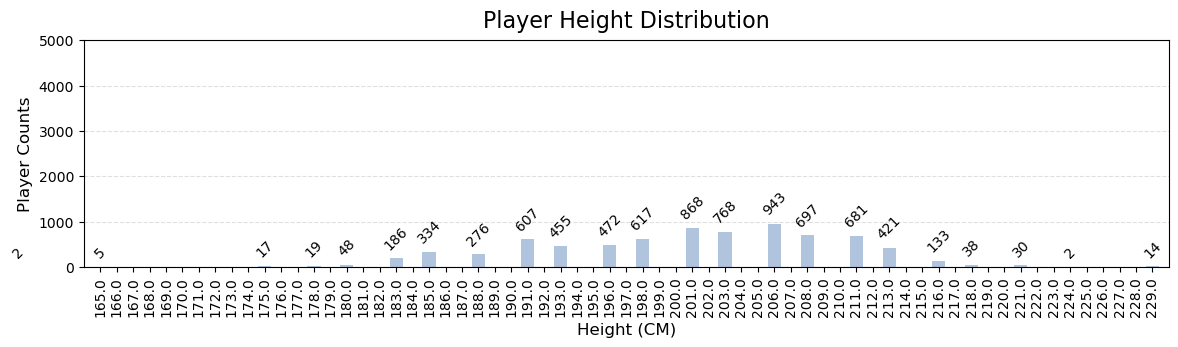

In [72]:
b = nba[['Player', 'height']]
bb = b.groupby('height').size()
bbb = bb[bb.values > 3000]

fig = plt.figure(figsize=(14, 3), dpi=100)
ax = fig.add_subplot(111)
mean = nba['height'].mean()
ax.bar(bb.index, bb.values, width=0.8, color='lightsteelblue')
ax.bar(bbb.index, bbb.values, width=0.8, color='royalblue')
ax.set_xticks(np.arange(165.0, 230.0, 1))
ax.set_xticklabels(np.arange(165.0, 230.0, 1), rotation=90)
ax.set_xlim(164,230)
for x,y in zip(bb.index, bb.values):
    ax.text(x, y+200, y, fontsize=10, rotation=45, horizontalalignment='center')
ax.set_ylim(0,5000)
ax.set_title('Player Height Distribution', fontsize=16, y=1.02)
ax.set_xlabel('Height (CM)', fontsize=12)
ax.set_ylabel('Player Counts', fontsize=12)
ax.yaxis.grid(alpha=0.4, ls='--')
plt.show()

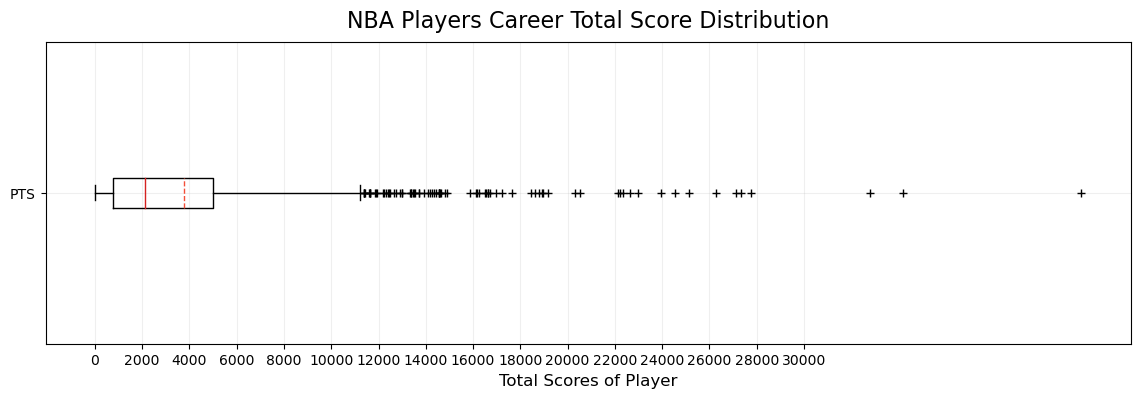

In [73]:
e = nba.groupby('Player')['PTS'].sum().sort_values(ascending=False)
ee = e.describe()
ee

fig = plt.figure(figsize=(14,4), dpi=100)
ax = fig.add_subplot(111)
ax.boxplot(e.values, widths=0.1, labels=['PTS'], vert=False, sym='+', patch_artist=False, meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True)
ax.set_xticks(np.arange(0,30001,2000))
ax.set_xlabel('Total Scores of Player', fontsize=12)
ax.set_title('NBA Players Career Total Score Distribution', fontsize=16, y=1.02)
ax.grid(alpha=0.2)
plt.show()

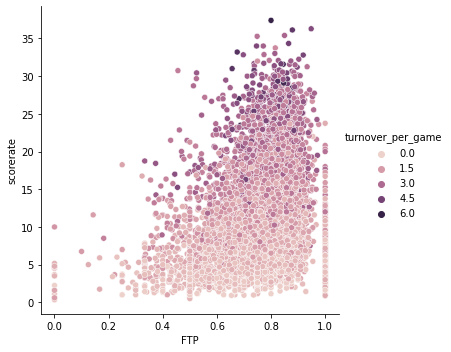

In [74]:
import seaborn as sns
sns.relplot(x="FTP", y="scorerate", data=nba, kind="scatter", hue="turnover_per_game");

In [75]:
corr = nba[feat_cols + [target]].corr()

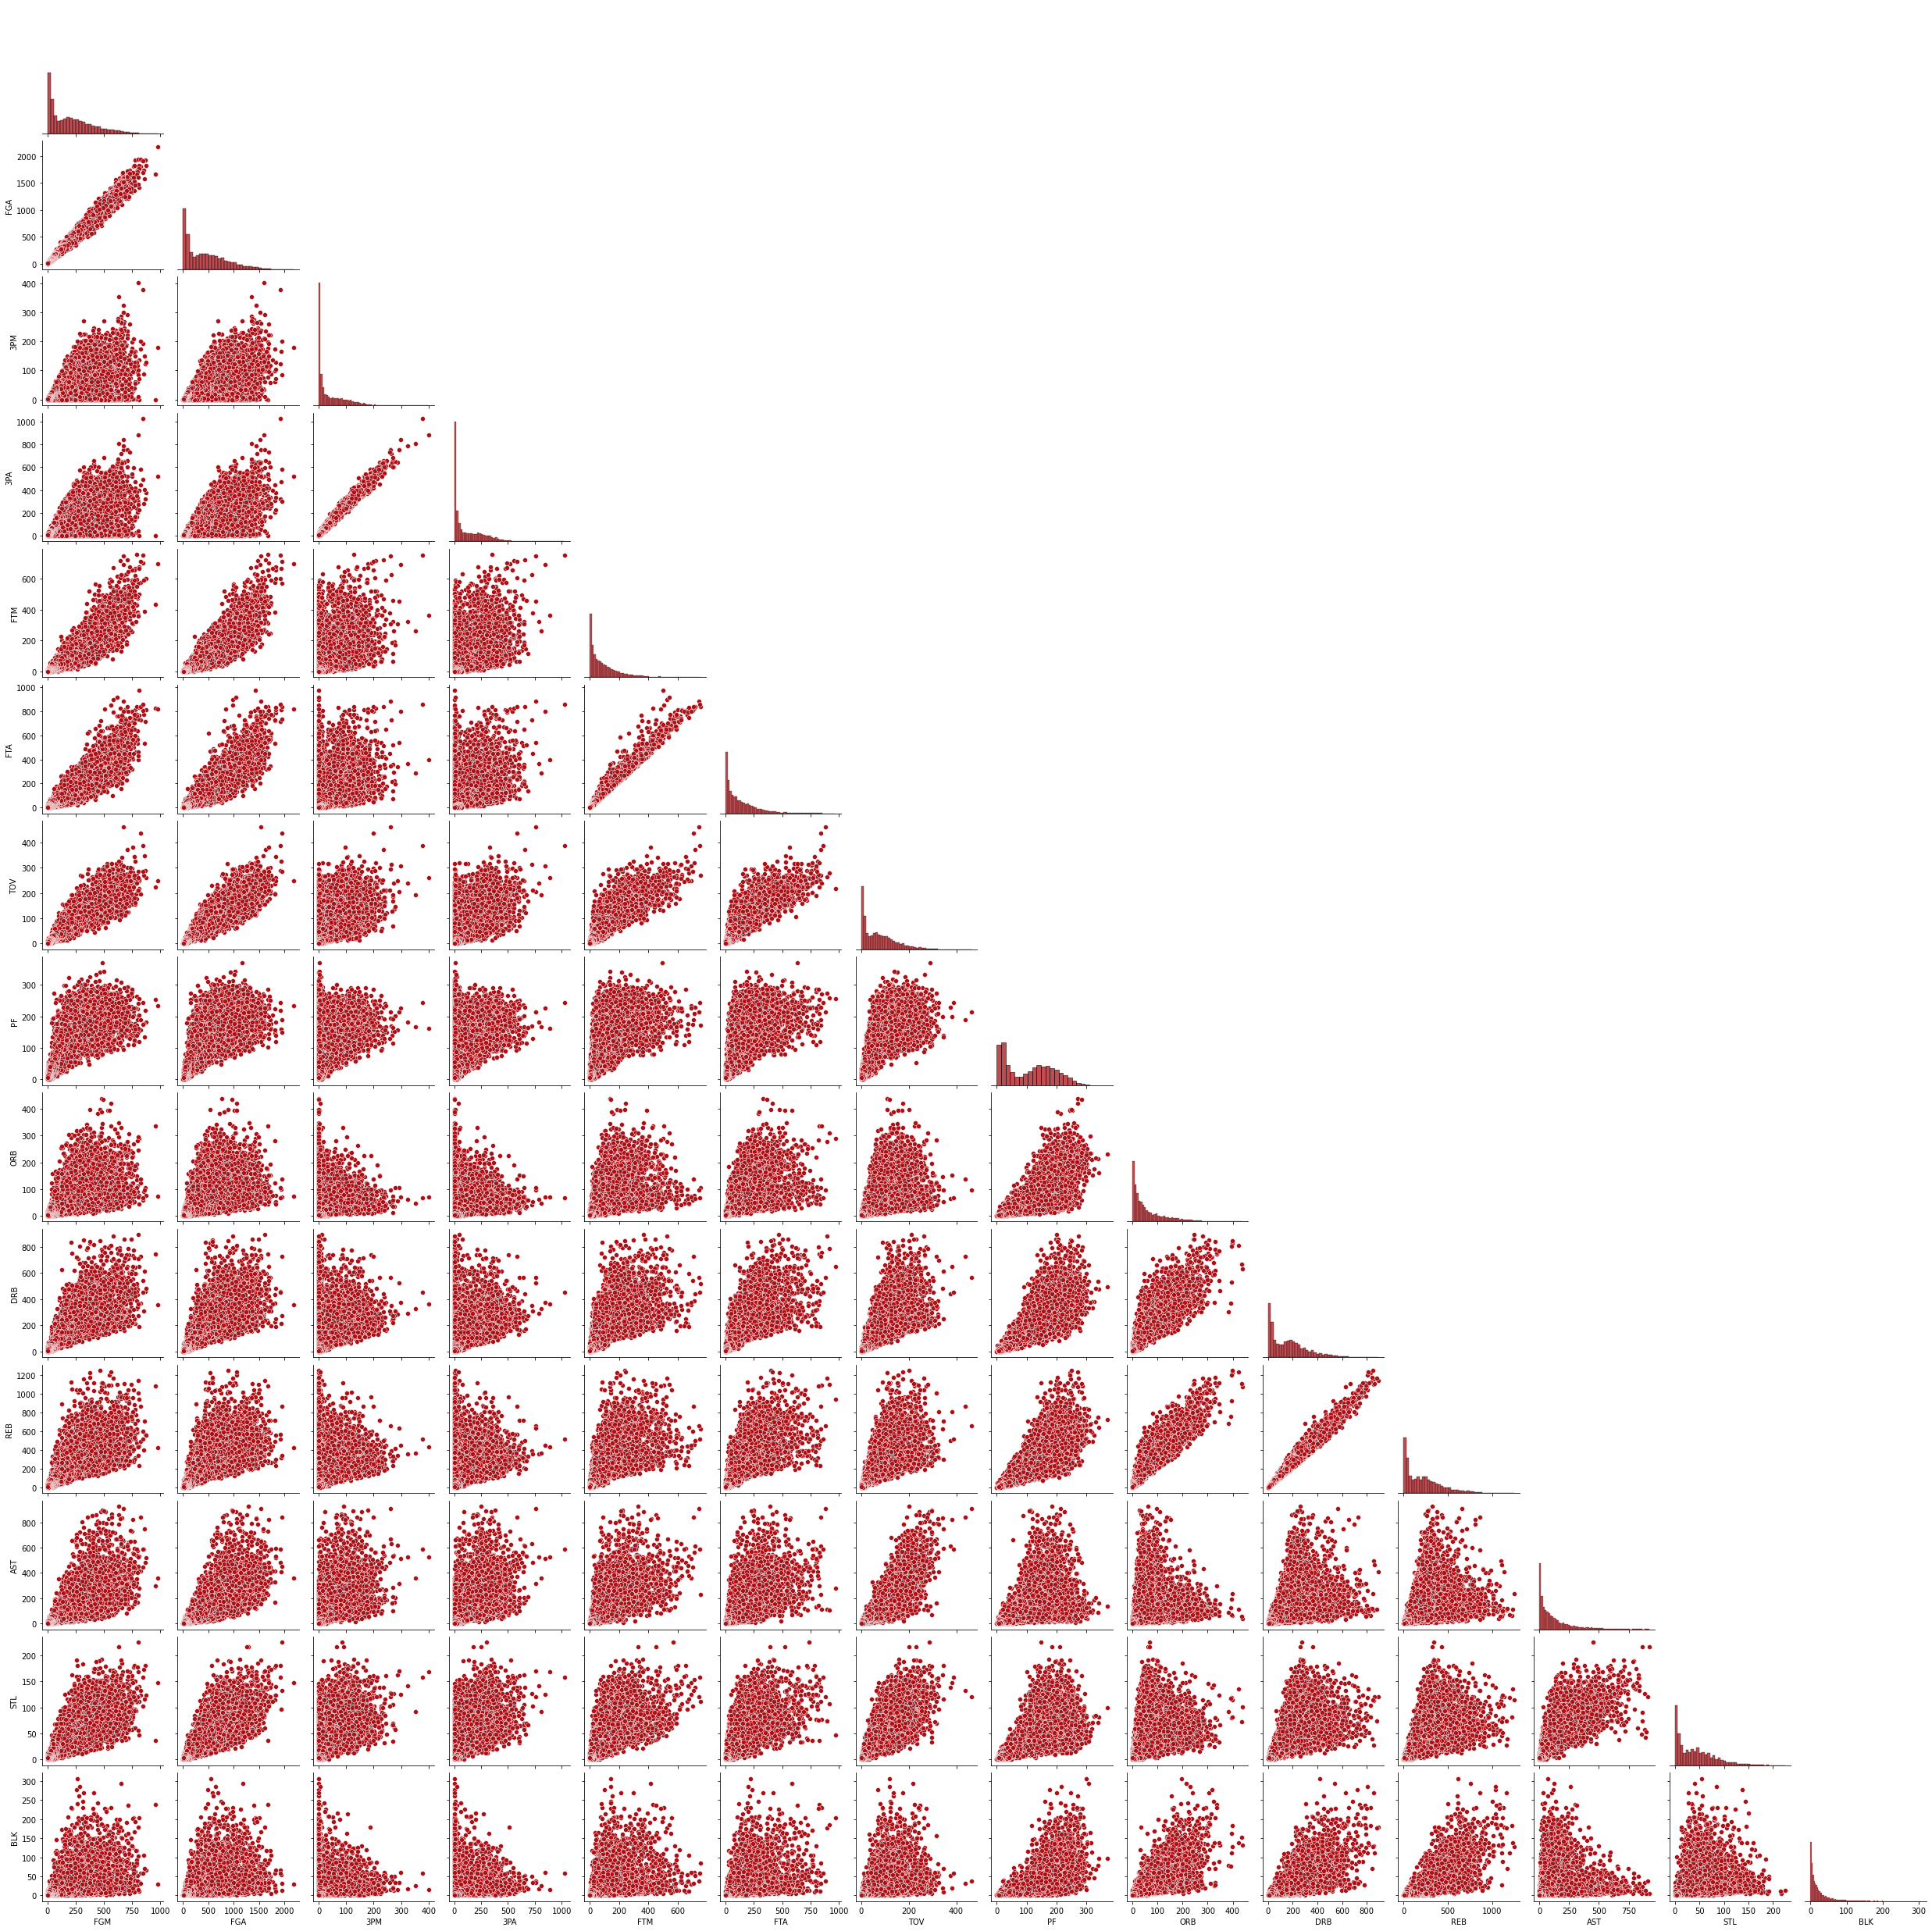

In [76]:
sns.set_palette(sns.color_palette("Reds_r"))

sns.pairplot(data=nba[['FGM', 'FGA', '3PM', '3PA', 'FTM', 'FTA', 'TOV', 'PF', 'ORB', 'DRB', 'REB', 'AST', 'STL', 'BLK']], 
             corner=True);

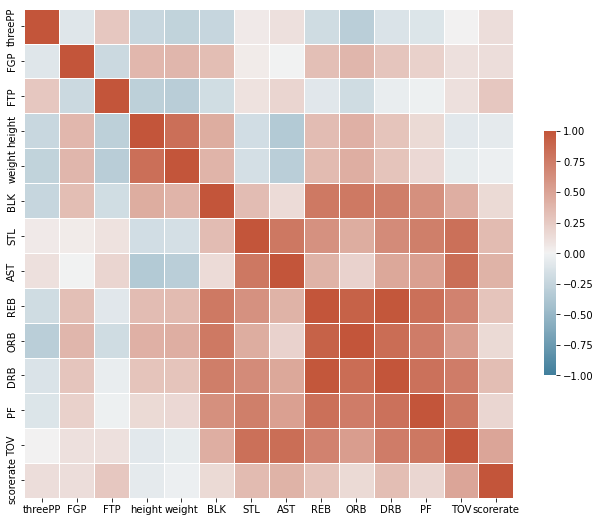

In [77]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmax=1, center=0, vmin=-1, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

## Training and test set : 2015-2020 and preprocessing

In [78]:

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
nba=clean_dataset(nba[feat_cols])
train_df, test_df = train_test_split(nba, test_size=0.3, random_state=123)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [79]:
X_train, y_train = train_df[feat_cols], train_df[target]
X_test, y_test = test_df[feat_cols], test_df[target]
X_train.info()
X_train = X_train.reset_index()
X_test = X_test.reset_index()

KeyError: 'scorerate'

In [ ]:
preprocessor = make_column_transformer(
     (SimpleImputer(), feat_cols),
    (StandardScaler(), feat_cols))

## Train a first model

In [54]:
dummy = DummyRegressor()


scores = cross_validate(dummy, X_train, y_train, cv=5, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.003313,0.000493,-0.000543,0.0
1,0.001939,0.000469,-0.000013,0.0
2,0.002068,0.000357,-0.000001,0.0
3,0.001474,0.000353,-0.000567,0.0
4,0.000955,0.000320,-0.001919,0.0


In [55]:
#reference: lecture 3
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
    return pd.Series(data=out_col, index=mean_scores.index)

In [56]:
results ={}


In [57]:
X_train_trans = preprocessor.fit_transform(X_train, y_train)

In [58]:
#kNN:
from sklearn.neighbors import KNeighborsRegressor
knn=KNeighborsRegressor()
knn.fit(X_train_trans, y_train)

knn.score(X_train_trans, y_train)

pipe_knn = make_pipeline(preprocessor, KNeighborsRegressor())
results["kNN"] = mean_std_cross_val_scores(
    KNeighborsRegressor(), X_train_trans, y_train, return_train_score=True
)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [59]:
results

{}

In [279]:
from sklearn.svm import SVR
# lgbm
pipe_lgbm = make_pipeline(preprocessor, LGBMRegressor(random_state=123))
results["lgbm"] = mean_std_cross_val_scores(
    pipe_lgbm, X_train, y_train, return_train_score=True
)

pipe_svm = make_pipeline(preprocessor,SVR())
results["svm"] = mean_std_cross_val_scores(
     pipe_svm, X_train, y_train, return_train_score=True
)



In [280]:
results

{'kNN': fit_time       0.001 (+/- 0.000)
 score_time     0.062 (+/- 0.006)
 test_score     0.482 (+/- 0.018)
 train_score    0.663 (+/- 0.002)
 dtype: object,
 'lgbm': fit_time       0.340 (+/- 0.123)
 score_time     0.024 (+/- 0.031)
 test_score     0.653 (+/- 0.009)
 train_score    0.872 (+/- 0.003)
 dtype: object,
 'svm': fit_time       0.800 (+/- 0.083)
 score_time     0.399 (+/- 0.014)
 test_score     0.340 (+/- 0.050)
 train_score    0.347 (+/- 0.005)
 dtype: object}

In [78]:
from sklearn.ensemble import RandomForestRegressor

In [283]:
rf = RandomForestRegressor(random_state=42)
pipe_rf = make_pipeline(preprocessor,rf)
results["rf"] = mean_std_cross_val_scores(
     pipe_rf, X_train, y_train, return_train_score=True
)

In [284]:
results

{'kNN': fit_time       0.001 (+/- 0.000)
 score_time     0.062 (+/- 0.006)
 test_score     0.482 (+/- 0.018)
 train_score    0.663 (+/- 0.002)
 dtype: object,
 'lgbm': fit_time       0.340 (+/- 0.123)
 score_time     0.024 (+/- 0.031)
 test_score     0.653 (+/- 0.009)
 train_score    0.872 (+/- 0.003)
 dtype: object,
 'svm': fit_time       0.800 (+/- 0.083)
 score_time     0.399 (+/- 0.014)
 test_score     0.340 (+/- 0.050)
 train_score    0.347 (+/- 0.005)
 dtype: object,
 'rf': fit_time       4.568 (+/- 0.122)
 score_time     0.032 (+/- 0.002)
 test_score     0.634 (+/- 0.005)
 train_score    0.948 (+/- 0.001)
 dtype: object}

### Hyperparameter Optimization

In [290]:
pipeline = Pipeline([
    ('classifier', LGBMRegressor())
])

params = {"classifier__max_depth": [5,10,100,200],
              "classifier__learning_rate": [0.1,0.5,0.9],
              "classifier__boosting_type":  ['gbdt', 'dart', 'goss'],
              "classifier__num_leaves": [5,10,50,100,200],
              "classifier__n_estimators": list(range(100, 500))
             }
random_search = RandomizedSearchCV(
   pipeline, param_distributions=params, n_jobs=-1, n_iter=20, cv=5, random_state=123
)
random_search.fit(X_train, y_train);

In [308]:
random_search.best_score_

0.6150829249805811

In [292]:

random_search.best_params_

{'classifier__num_leaves': 50,
 'classifier__n_estimators': 432,
 'classifier__max_depth': 10,
 'classifier__learning_rate': 0.5,
 'classifier__boosting_type': 'dart'}

### Feature Selection

In [294]:
from sklearn.feature_selection import SequentialFeatureSelector
lgbm = LGBMRegressor(random_state=42, num_leaves=50, n_estimators=432, max_depth=10, learning_rate=0.5,)
pipe_forward = make_pipeline(
    SequentialFeatureSelector(
        LogisticRegression(max_iter=1000), direction="forward"
    ),
    lgbm
)
pd.DataFrame(cross_validate(pipe_forward, X_train, y_train, return_train_score=True)).mean()

fit_time       0.963039
score_time     0.018410
test_score     0.408828
train_score    0.999975
dtype: float64

In [296]:
from sklearn.feature_selection import SequentialFeatureSelector
pipe_forward = make_pipeline(
    SequentialFeatureSelector(
        LogisticRegression(max_iter=1000), direction="backward"
    ),
    lgbm
)
pd.DataFrame(cross_validate(pipe_forward, X_train, y_train, return_train_score=True)).mean()

fit_time       0.810592
score_time     0.018776
test_score     0.352472
train_score    0.998959
dtype: float64

In [313]:
from sklearn.feature_selection import RFECV

rfe_cv = RFECV(LGBMRegressor(), cv=5)
rfe_cv.fit(X_train, y_train)
print(rfe_cv.support_)


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


r^2 score does not improve when using forward and backward selection;
recursive feature elimination keeps all current features;
-> so does not remove any feature

## Hyperparameter Optimization for Random Forest

In [300]:
pipeline = Pipeline([
    ('classifier', RandomForestRegressor())
])
#     'bootstrap': [True, False],
#     'max_depth': list(range(2, 10)),
#     'max_features': ['auto', 'sqrt'],
#     'min_samples_leaf': list(range(1, 4)),
#     'min_samples_split': list(range(2, 10)),
#     'n_estimators': list(range(100, 500))
params = {"classifier__max_depth": [3,5,10],
              "classifier__max_features": [1, 3, 5, 10],
              "classifier__min_samples_split": [3, 10, 20],
              "classifier__min_samples_leaf": [1, 3, 10],
              "classifier__bootstrap": [True, False],
              "classifier__n_estimators": list(range(100, 500))}
random_search = RandomizedSearchCV(
   pipeline, param_distributions=params, n_jobs=-1, n_iter=20, cv=5, random_state=123
)
random_search.fit(X_train, y_train);

In [306]:

random_search.best_params_

{'classifier__n_estimators': 312,
 'classifier__min_samples_split': 3,
 'classifier__min_samples_leaf': 1,
 'classifier__max_features': 10,
 'classifier__max_depth': 10,
 'classifier__bootstrap': False}

In [307]:
random_search.best_score_

0.6150829249805811

## Feature Importances

In [20]:
import shap

pipe_bestmodel = make_pipeline(preprocessor, RandomForestRegressor())
pipe_bestmodel.fit(X_train, y_train);

shap_explainer = shap.TreeExplainer(pipe_bestmodel.named_steps["randomforestregressor"])
train_lgbm_shap_values = shap_explainer.shap_values(X_train_trans)
values = np.abs(train_lgbm_shap_values[1]).mean(0)
pd.DataFrame(data=values, index=feat_cols, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]
# global feature importances.

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
shap.initjs()

In [ ]:
shap.dependence_plot("FTP", train_lgbm_shap_values[1], X_train_trans)

## Test

In [ ]:
pipe_bestmodel.score(X_test,y_test)